## Video Embedding Clustering with Feluda
This notebook demonstrates how to use the [`feluda`](https://github.com/tattle-made/feluda) to extract video embeddings and cluster them into N clusters or auto clusters. It includes:
- Setting up Feluda and its operators.
- Using video data from a subset of the [UCF101 video dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) dataset. We are using this for demo, but can be replaced with any video dataset.
- Generating video embeddings using feluda CLIP [video operator](https://pypi.org/project/feluda-vid-vec-rep-clip/).
- Using Feluda's [clustering operator](https://pypi.org/project/feluda-cluster-embeddings/) to cluster vidoes.
- Visualizing the clusters with video thumbnails.

### Install Required Packages
Install dependencies conditionally based on whether the notebook is running in Colab or locally.

In [ ]:
%%time
import sys

IN_COLAB = "google.colab" in sys.modules
print("Running Notebook in Google Colab" if IN_COLAB else "Running Notebook locally")

if IN_COLAB:
    # Since Google Colab has preinstalled libraries like tensorflow and numba, we create a folder called feluda_custom_venv and isolate the environment there.
    # This is done to avoid any conflicts with the preinstalled libraries.
    !pip install uv
    !mkdir -p /content/feluda_custom_venv
    !uv pip install --target=/content/feluda_custom_venv --prerelease allow feluda feluda-vid-vec-rep-clip feluda-cluster-embeddings opencv-python matplotlib > /dev/null 2>&1

    sys.path.insert(0, "/content/feluda_custom_venv")
else:
    !uv pip install feluda feluda-vid-vec-rep-clip feluda-cluster-embeddings opencv-python matplotlib > /dev/null 2>&1

Running Notebook locally
Using Python 3.10.12 environment at: /home/aatman/Aatman/Tattle/feluda/.venv
Audited 6 packages in 11ms
CPU times: user 6.38 ms, sys: 4.13 ms, total: 10.5 ms
Wall time: 138 ms


In [2]:
import os
import tarfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

from feluda.factory import VideoFactory

### Initializing Feluda class with config file

We'll use two operators for this example. One for extracting embeddings and other for clustering.

In [ ]:
from feluda.operators import ClusterEmbeddings, VidVecRep

cluster_operator = ClusterEmbeddings()
vid_vec_clip_operator = VidVecRep()

### Data Preparation

In [6]:
dataset_name = "UCF101_subset/train"
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"

# Download and extract the UCF101 subset dataset
print("Downloading and extracting dataset...")
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

with tarfile.open(file_path) as t:
    t.extractall(".")
print(f"Dataset extracted to {dataset_name}")

UCF101_subset.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

Dataset extracted to UCF101_subset/train


/var/folders/4p/bw6h5x8x1nb_17vsgfc12dz00000gn/T/ipykernel_40587/954250746.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(".")


In [7]:
# Create thumbnails directory
thumbnail_dir = Path("thumbnails")
thumbnail_dir.mkdir(exist_ok=True)

In [8]:
def get_video_thumbnail(video_path: str, save_path: str) -> str | None:
    """Extract and save the first frame from the video as a thumbnail.

    Args:
        video_path: Path to the video file
        save_path: Directory to save the thumbnail

    Returns:
        Path to the saved thumbnail or None if extraction failed
    """
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()  # Read the first frame

    if ret:
        thumbnail_path = os.path.join(
            save_path, os.path.basename(video_path).replace(".avi", "_thumbnail.jpg")
        )
        cv2.imwrite(thumbnail_path, frame)  # Save the thumbnail as a JPEG
        cap.release()
        return thumbnail_path  # Return the path to the saved thumbnail

    cap.release()
    return None

### Video Processing and Embedding Extraction

In [9]:
print("Processing videos and extracting embeddings...")
operator_parameters = []
sub_folder_name = os.listdir(f"{dataset_name}")

# Process videos from each class directory
for class_dir in tqdm(sub_folder_name, desc="Processing classes"):
    temp_list = os.listdir(os.path.join(dataset_name, class_dir))

    # Process up to 5 videos per class
    video_count = 0
    for video_file in temp_list:
        if video_file == "UCF101" or video_count >= 5:
            continue

        video_full_path = os.path.join(dataset_name, class_dir, video_file)

        try:
            # Extract and save the video thumbnail
            thumbnail_path = get_video_thumbnail(video_full_path, thumbnail_dir)

            # Process video and extract embedding
            video = VideoFactory.make_from_file_on_disk(video_full_path)
            embedding = vid_vec_clip_operator.run(video)
            average_vector = next(embedding)

            # Store video path and embedding
            operator_parameters.append(
                {
                    "payload": video_full_path,
                    "embedding": average_vector.get("vid_vec"),
                    "class": class_dir,  # Store class name for later analysis
                }
            )

            video_count += 1
        except Exception as e:
            print(f"Error processing {video_full_path}: {e}")
            continue

print(f"Successfully processed {len(operator_parameters)} videos")

Processing videos and extracting embeddings...


Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully processed 50 videos


### Clustering Videos

In [10]:
# Apply clustering to the video embeddings
print("Clustering video embeddings...")
n_clusters = 10  # Number of clusters to create
clusters = cluster_operator.run(
    operator_parameters, n_clusters=n_clusters, modality="video"
)

# Sort clusters by label for consistent display
clusters = {key: clusters[key] for key in sorted(clusters)}

Clustering video embeddings...


### Visualizing Clusters

In [11]:
# Function to load thumbnails
def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder.

    Args:
        payload: Path to the video file

    Returns:
        Loaded thumbnail image or None if not found
    """
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_dir, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    print(f"Thumbnail not found for {video_filename}")
    return None

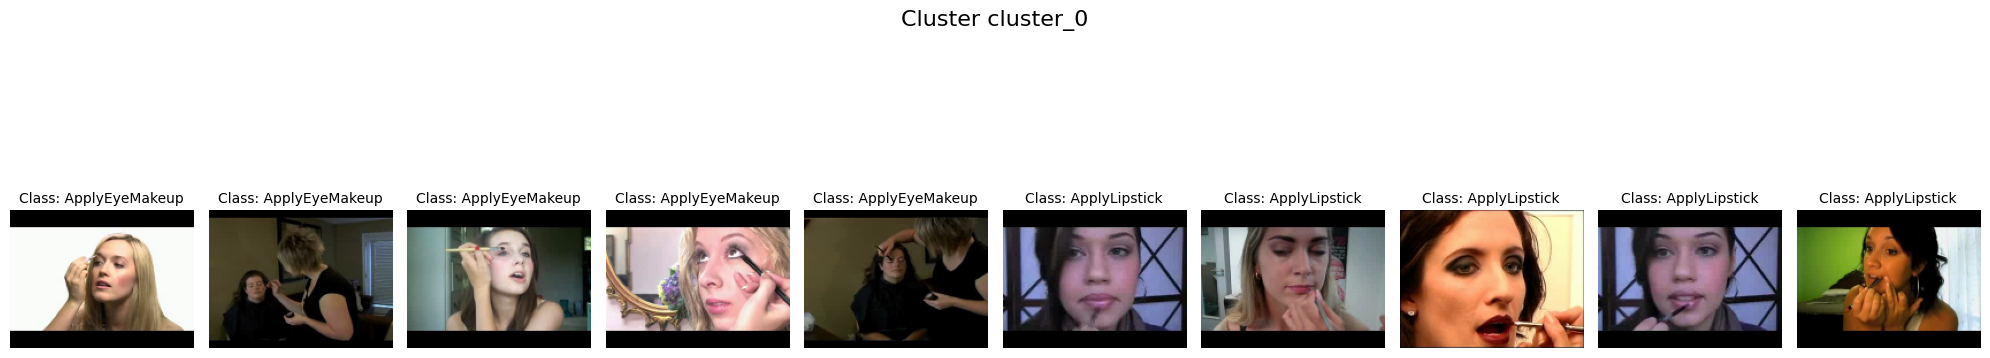

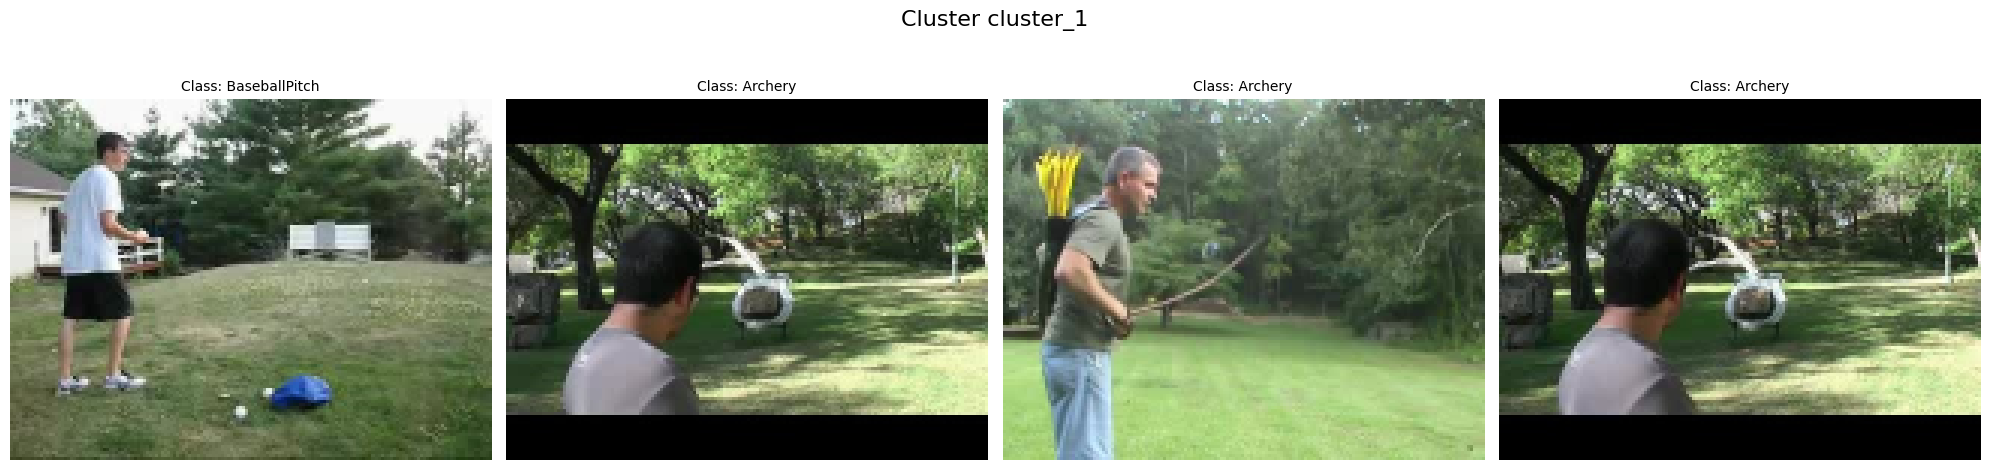

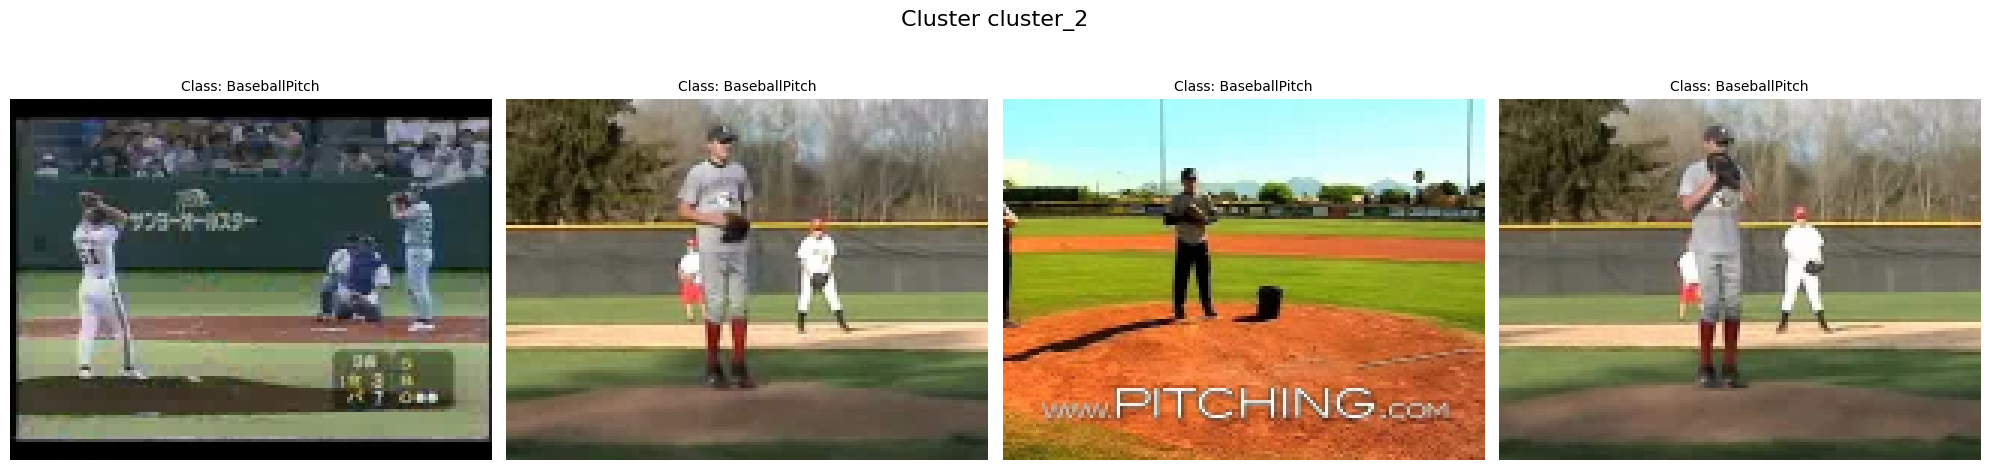

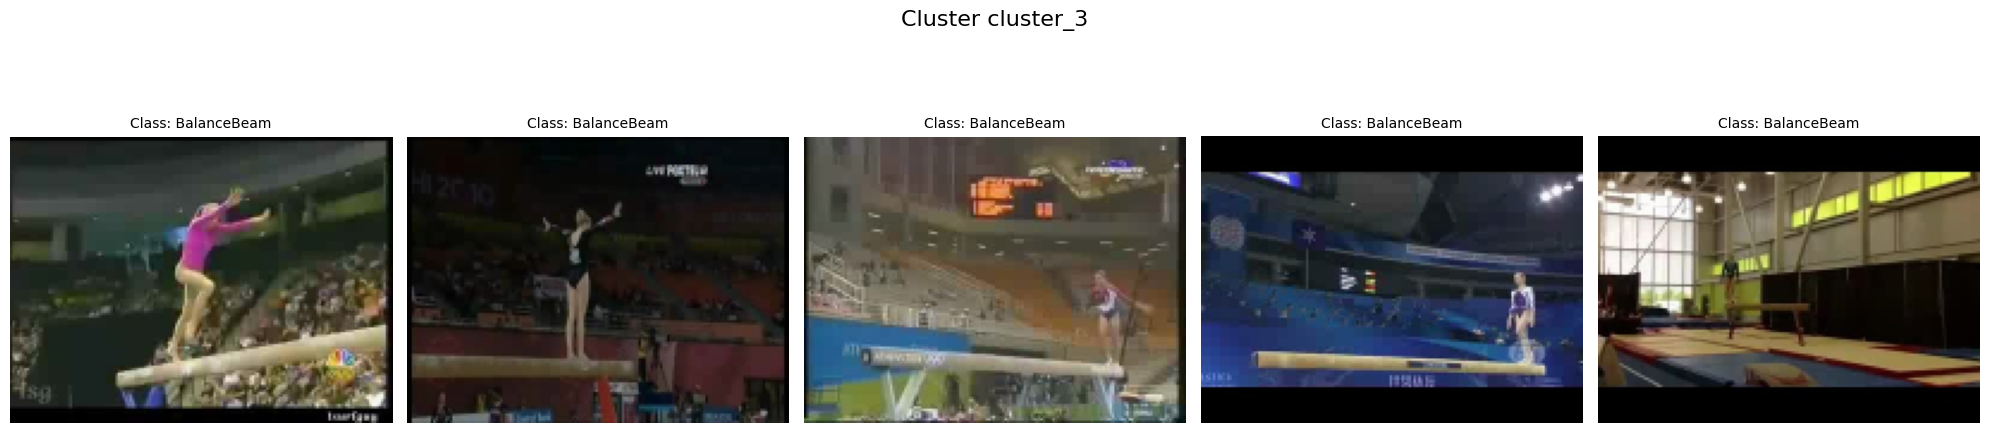

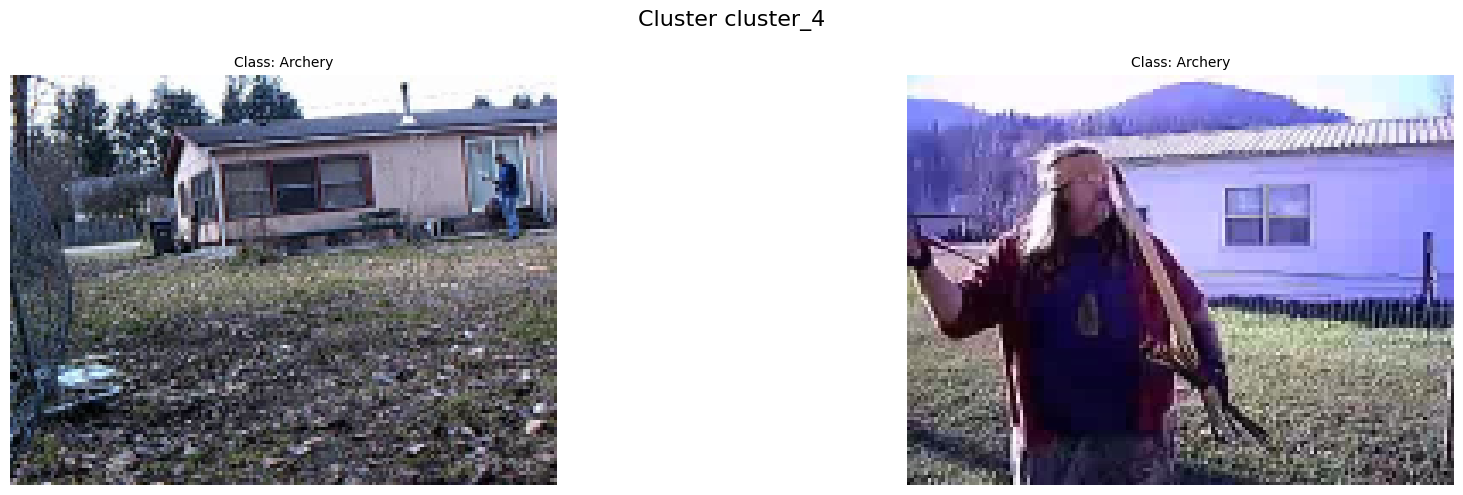

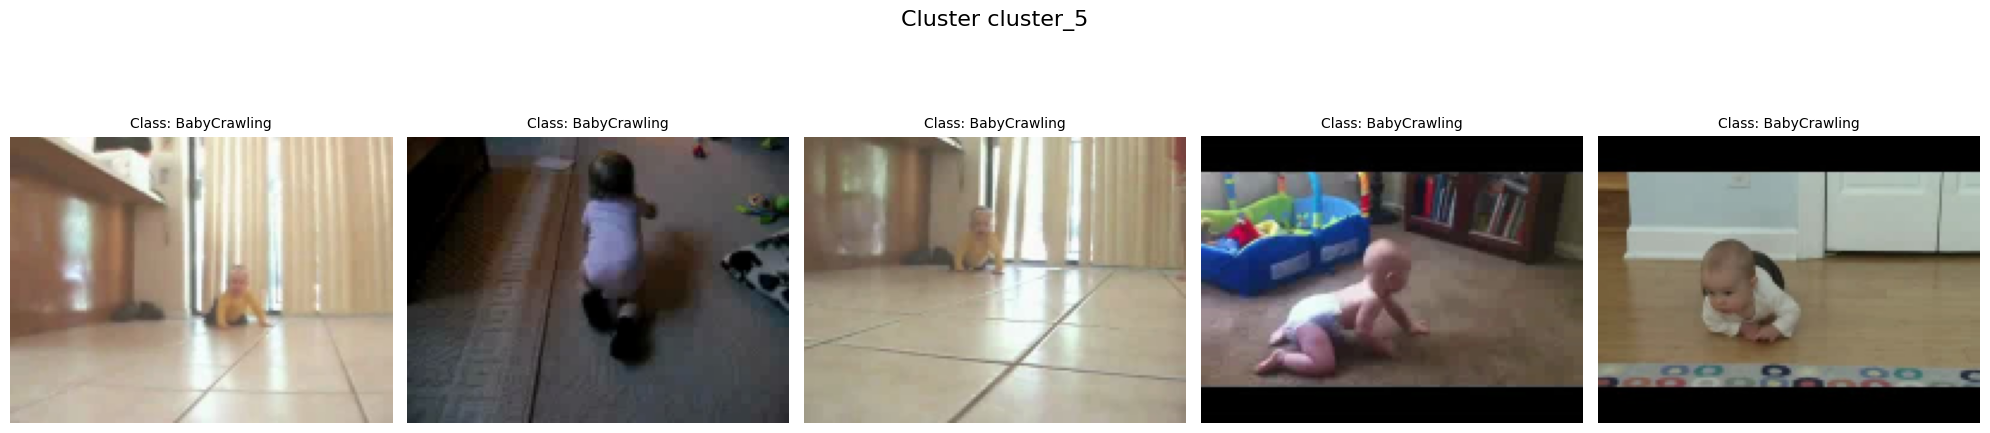

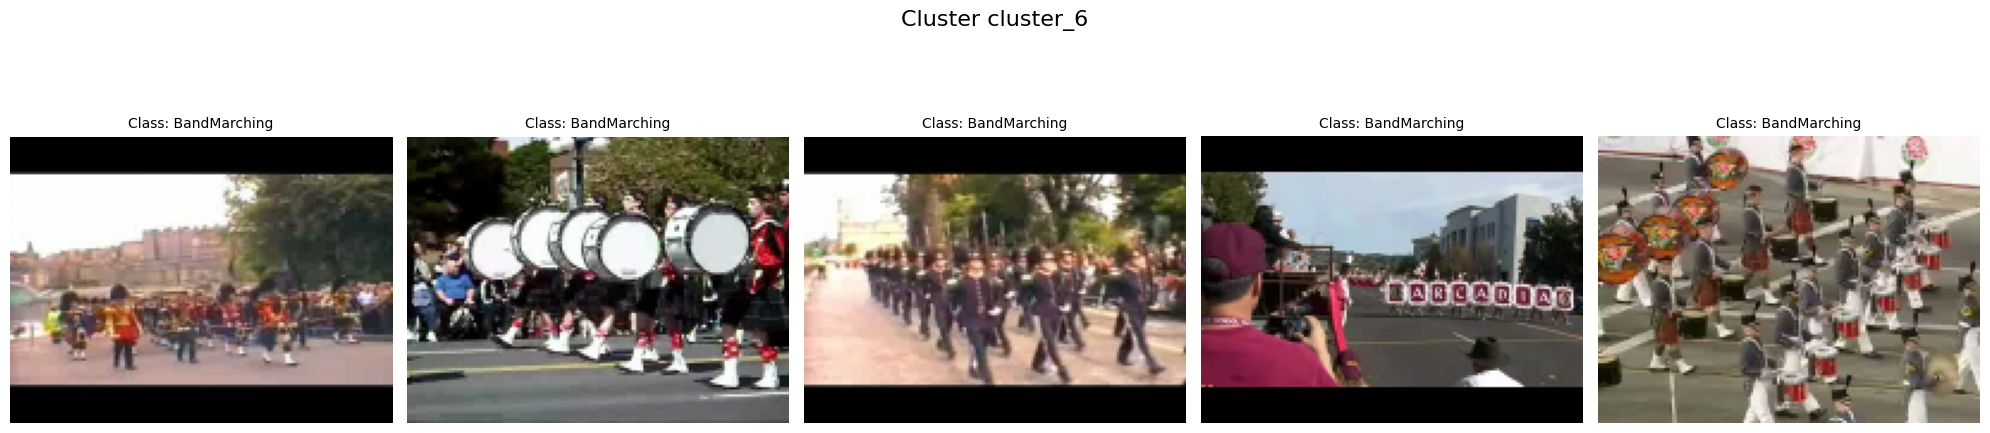

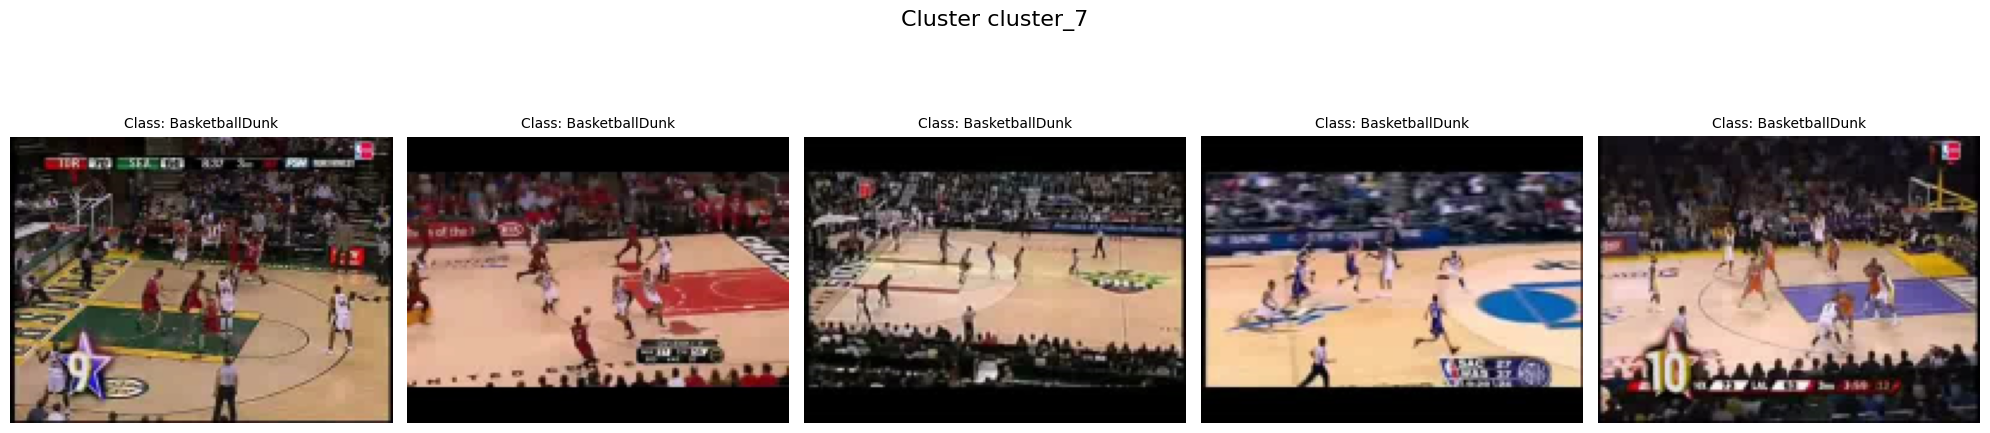

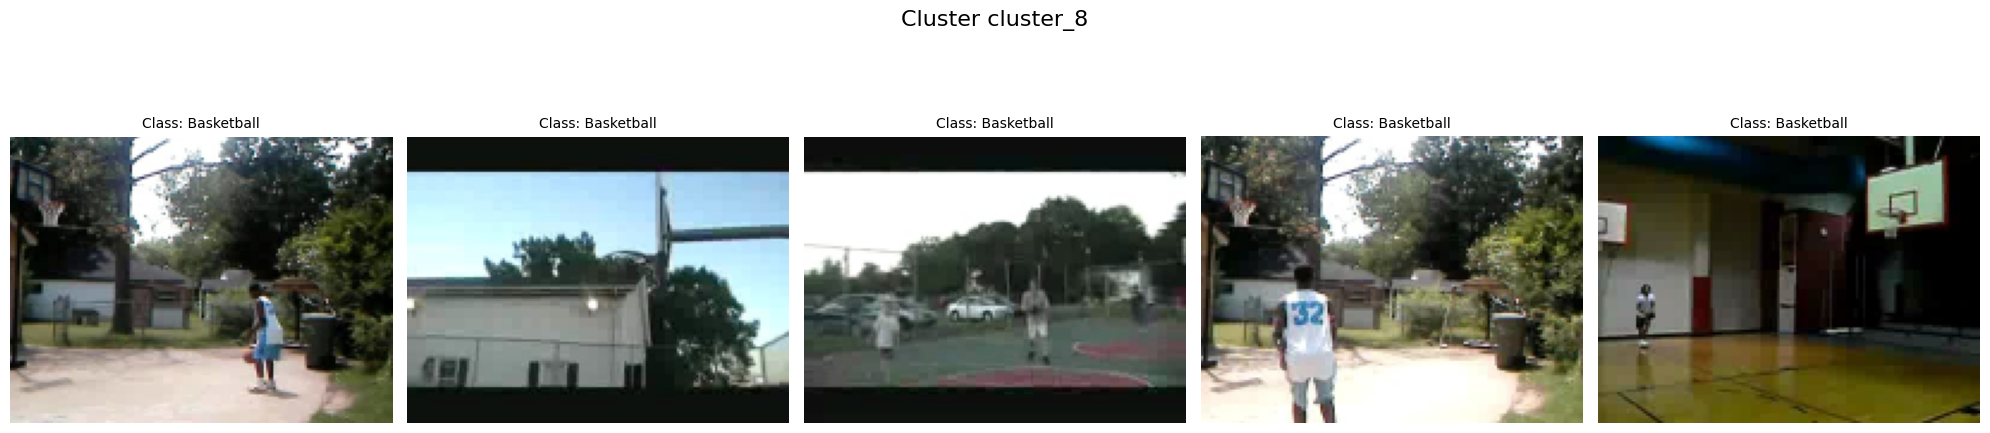

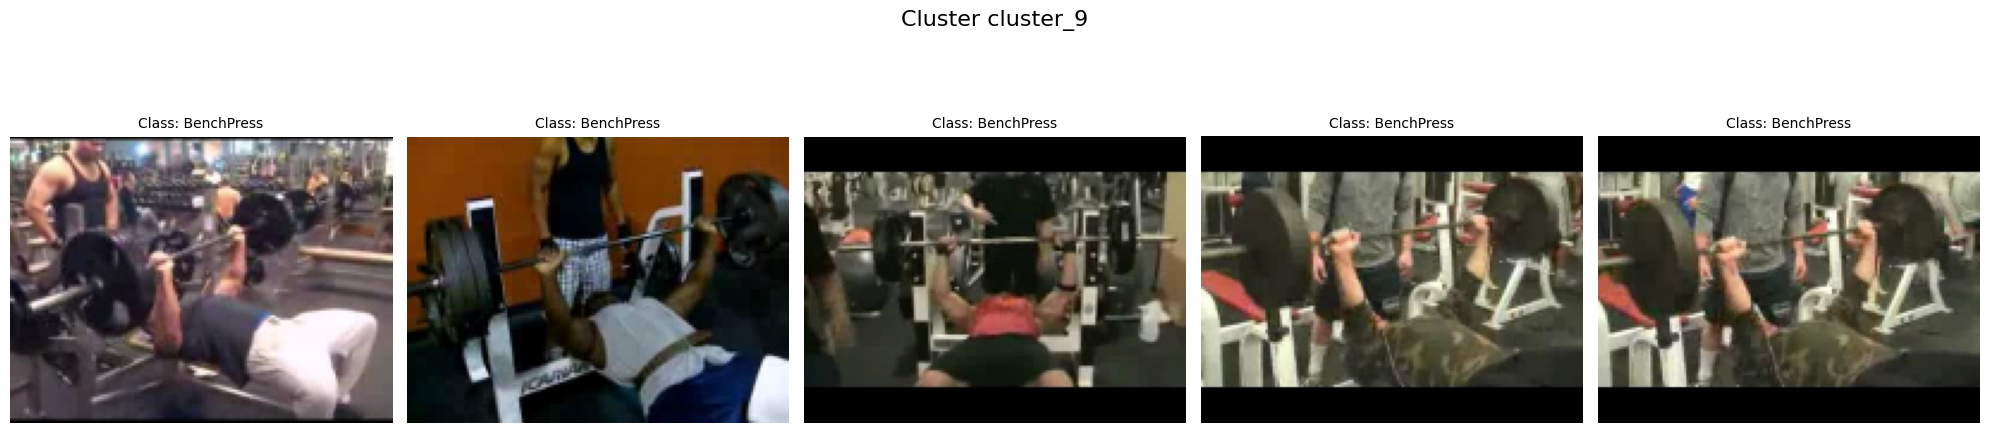

In [12]:
for cluster_label, video_paths in clusters.items():
    num_videos = len(video_paths)

    # Create a subplot for each video in the cluster
    fig, axes = plt.subplots(1, max(1, num_videos), figsize=(20, 5))

    # Handle case where there's only one video in a cluster
    if num_videos == 1:
        axes = [axes]

    # Plot thumbnails
    for i, video_path in enumerate(video_paths):
        # Extract class name from path for display
        class_name = os.path.basename(os.path.dirname(video_path))

        video_thumbnail = load_thumbnail(video_path)
        if video_thumbnail is not None:
            # Resize and convert color format
            video_thumbnail = cv2.cvtColor(
                cv2.resize(video_thumbnail, (160, 120)), cv2.COLOR_BGR2RGB
            )

            # Display thumbnail
            axes[i].imshow(video_thumbnail)
            axes[i].set_title(f"Class: {class_name}", fontsize=10)
            axes[i].axis("off")

    # Set overall title for the cluster
    plt.suptitle(f"Cluster {cluster_label}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [13]:

import shutil

# Remove thumbnail directory
if os.path.exists(thumbnail_dir):
    shutil.rmtree(thumbnail_dir)
    print(f"Removed {thumbnail_dir}")

# Remove dataset directory
if os.path.exists("UCF101_subset"):
    shutil.rmtree("UCF101_subset")
    print("Removed UCF101_subset")

# Remove downloaded dataset file
if os.path.exists(file_path):
    os.remove(file_path)
    print("Removed dataset")


cluster_operator.cleanup()
vid_vec_clip_operator.cleanup()

Removed thumbnails
Removed UCF101_subset
Removed dataset
